In [66]:
import numpy as np
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web


from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


Load Data

In [67]:
DATA_STORE = '../data/assets.h5'

In [68]:
idx = pd.IndexSlice
START = 2000
END = 2018

In [69]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              )
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [70]:
prices = prices.unstack("ticker")

In [71]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [72]:
prices.head()

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,37.06,23.5,NaN,NaN,NaN,NaN,3.7025,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,36.50,22.5,NaN,NaN,NaN,NaN,3.5475,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,37.13,23.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,35.25,22.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,38.00,21.5,NaN,NaN,NaN,NaN,3.4850,NaN,NaN


In [73]:
stocks.head()

,marketcap,ipoyear,sector
ticker,,,
PIH,43090000.0,2014.0,Finance
PIHPP,NaN,NaN,Finance
TURN,70330000.0,NaN,Finance
FLWS,833390000.0,1999.0,Consumer Services
FCCY,178140000.0,NaN,Finance


In [74]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


Find common stocks

In [75]:
shared_stocks = list(set(prices.columns) & set(stocks.index))

In [76]:
stocks = stocks.loc[shared_stocks, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, AET to WHF
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.4+ KB


In [77]:
prices = prices.loc[:, shared_stocks]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, AET to WHF
dtypes: float64(2412)
memory usage: 86.6 MB


We convert day time to month time

In [78]:
monthly_prices = prices.resample('1M').last()

monthly_prices

ticker,AET,PPG,OLN,CSL,XNCR,FLDM,INWK,HURC,OC,JWN,...,STRA,CELG,ADM,HAE,MYRG,NCLH,NVDA,ATHN,DAL,WHF
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,5.945855,17.200134,8.320935,12.086620,NaN,NaN,NaN,3.699851,NaN,7.116116,...,16.526892,2.906250,8.235290,13.030,NaN,NaN,2.865664,NaN,NaN,NaN
2000-02-29,4.591429,15.543295,7.457293,12.460460,NaN,NaN,NaN,4.356754,NaN,6.919986,...,21.441169,6.895833,7.078024,11.905,NaN,NaN,4.948798,NaN,NaN,NaN
2000-03-31,6.197089,16.465568,8.539803,15.044322,NaN,NaN,NaN,3.341801,NaN,9.579521,...,21.084357,4.148333,7.253919,11.250,NaN,NaN,6.532414,NaN,NaN,NaN
2000-04-30,6.509679,17.117140,8.539803,15.491891,NaN,NaN,NaN,3.864077,NaN,9.030728,...,16.712091,5.882500,6.992187,11.500,NaN,NaN,6.891975,NaN,NaN,NaN
2000-05-31,7.507274,15.894382,8.056745,15.862190,NaN,NaN,NaN,3.879354,NaN,7.966862,...,20.321123,4.812500,8.438144,10.655,NaN,NaN,8.722257,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30,180.180000,116.850000,35.640000,114.970000,21.71,5.95,10.85,44.600000,88.35,45.450000,...,99.230000,100.830000,39.880000,57.800,35.56,54.16,200.710000,132.89,52.92,14.09
2017-12-31,180.390000,116.820000,35.580000,113.650000,21.92,5.89,10.03,42.200000,91.94,47.380000,...,89.580000,104.360000,40.080000,58.080,35.73,53.25,193.500000,133.04,56.00,13.42
2018-01-31,186.820000,118.730000,37.280000,114.210000,22.76,6.13,10.01,45.150000,92.97,49.310000,...,92.480000,101.200000,42.950000,64.650,33.88,60.74,245.800000,125.31,56.77,12.99


In [79]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data['return_{}m'.format(lag)] = monthly_prices.pct_change(lag).stack().pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1)



In [80]:
data = data.swaplevel().dropna()
data

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,
AET,2001-01-31,-0.068924,0.065804,0.097683,0.055455,0.032644,0.032148
PPG,2001-01-31,-0.002807,0.052473,0.014388,0.024414,-0.015219,-0.011835
OLN,2001-01-31,-0.190691,0.017183,0.006736,0.026241,0.004814,0.005782
CSL,2001-01-31,-0.063810,-0.025254,-0.010063,-0.018058,-0.001242,0.019949
HURC,2001-01-31,0.018000,0.027474,0.017731,-0.011109,-0.014053,-0.006971
...,...,...,...,...,...,...,...
NCLH,2018-03-31,-0.070826,-0.067031,-0.002384,-0.003672,-0.002941,0.003449
NVDA,2018-03-31,-0.068099,-0.042141,0.052369,0.039477,0.050754,0.062686
ATHN,2018-03-31,0.008444,0.060458,0.019366,0.021054,0.000292,0.018804


Drop Stocks with less than 10 years of return

In [82]:
min_obs = 120
obs = data.groupby(level='ticker').size()
keep = nobs[obs>min_obs].index

data = data.loc[idx[keep,:],:]
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m  
ticker date                    
A      2001-01-31   -0.015988  
       2001-02-28   -0.084537  
       2001-03-31   -0.096606  
       2001-04-30   -0.066102  
       2001-05-31   -0.063425  
...                       ...  
ZUMZ   2017-11-30   -0.010687  
       2017-12-31   -0.003996  
       2018-01-31    0.002864  
       2018-02-28   -0.002905  
       2018-03-31    0.021422  

[360752 rows x 6 columns]

In [83]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000
mean,0.012255,0.009213,0.008181,0.007025,0.006552,0.006296
std,0.114236,0.081170,0.066584,0.048474,0.039897,0.034792
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046464,-0.030716,-0.023961,-0.014922,-0.011182,-0.009064
50%,0.009448,0.009748,0.009744,0.009378,0.008982,0.008726
75%,0.066000,0.049249,0.042069,0.031971,0.027183,0.024615
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


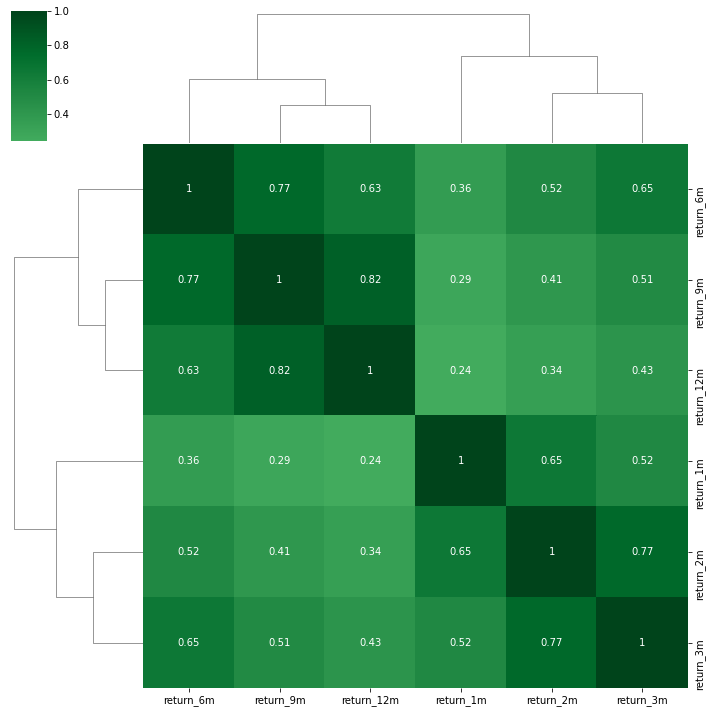

In [87]:
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Greens')

Rolling Factor Betas

In [93]:

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2000-01-31,-0.0474,0.0445,-0.0189,-0.0629,0.0474
2000-02-29,0.0245,0.1838,-0.0981,-0.1876,-0.0035
2000-03-31,0.0520,-0.1539,0.0823,0.1182,-0.0161
2000-04-30,-0.0640,-0.0496,0.0725,0.0767,0.0562
2000-05-31,-0.0442,-0.0387,0.0483,0.0418,0.0132
...,...,...,...,...,...
2021-05-31,0.0029,0.0119,0.0704,0.0234,0.0310
2021-06-30,0.0275,-0.0025,-0.0776,-0.0214,-0.0099
2021-07-31,0.0127,-0.0456,-0.0175,0.0536,-0.0055


In [94]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2001-01-31  0.0313  0.0545 -0.0511 -0.0546 -0.0505  -0.003653
       2001-02-28 -0.1005  0.0279  0.1248  0.0912  0.0906  -0.329564
       2001-03-31 -0.0726  0.0236  0.0643  0.0339  0.0390  -0.146389
       2001-04-30  0.0794 -0.0088 -0.0469 -0.0348 -0.0318   0.269444
       2001-05-31  0.0072  0.0359  0.0336  0.0025  0.0191  -0.140220
...                   ...     ...     ...     ...     ...        ...
ZUMZ   2017-11-30  0.0312 -0.0035 -0.0005  0.0317 -0.0010   0.235127
       2017-12-31  0.0106 -0.0107  0.0003  0.0075  0.0166  -0.044725
       2018-01-31  0.0558 -0.0325 -0.0136 -0.0072 -0.0101  -0.003601
       2018-02-28 -0.0365  0.0032 -0.0103  0.0056 -0.0232  -0.050602
       2018-03-31 -0.0235  0.0359 -0.0023 -0.0048  0.0000   0.197970

[360752 rows x 6 columns]

In [96]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [97]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000,360752.000000
mean,0.979934,0.626333,0.124406,-0.060456,0.016843,1.489364
std,0.916707,1.252218,1.603406,1.904381,2.159877,3.301100
min,-9.799998,-10.379596,-14.877822,-22.862746,-18.509338,-33.182035
25%,0.464833,-0.118656,-0.708147,-0.970885,-1.074246,0.000000
50%,0.930228,0.541269,0.096694,0.041176,0.041508,1.218302
75%,1.445027,1.303312,0.949285,0.951269,1.136353,3.147949
max,10.878797,10.438675,15.046664,16.765575,16.855115,33.792600


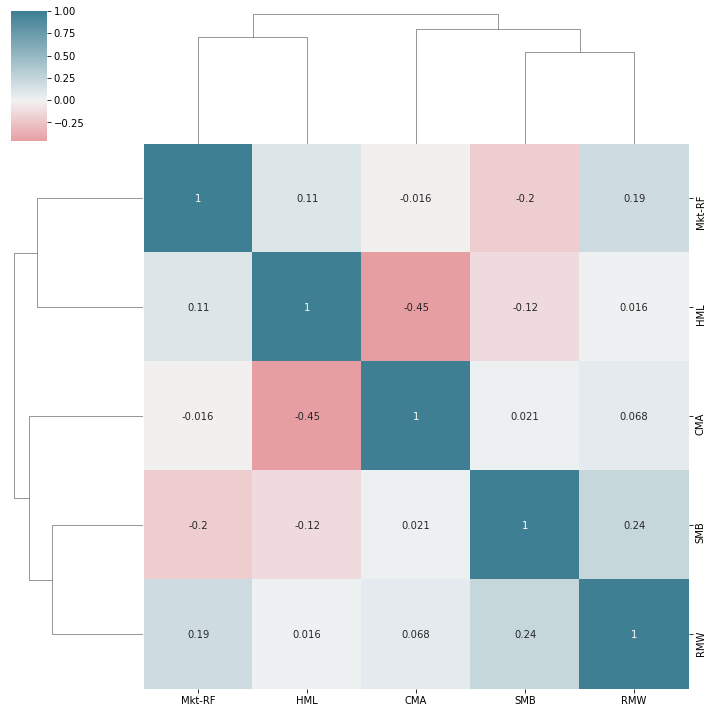

In [99]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);